<a href="https://colab.research.google.com/github/DanielFadlon/LWSM/blob/main/LWSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **LWSM (Light-Weight Signature Matching)**
A framework for a resource limited service using PDS (Probabilistic Data Structure) and AI powered methods.

In [1]:
path2project = 'drive/MyDrive/AIForCyber/LWSM'
# Define a path to save the vectorized features (to prevent from creating them each time)
path2ember = f'{path2project}/ember2018'
# Define the given initial blacklist file path
path2malicious_sha256_ember = f'{path2project}/task1_malicious_sha256_ember.txt'

# data is the folder with the clean and prepared data
gdrive_data_folder = f'{path2project}/data1'
# fiures from notebook
gdrive_figures_folder = f'{path2project}/figures'

### All additional packages:

In [2]:
!pip install git+https://github.com/zivido/ember-3.9.git
!pip install lief
!pip install bitarray
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/zivido/ember-3.9.git to /tmp/pip-req-build-krr5lsc9
  Running command git clone --filter=blob:none --quiet https://github.com/zivido/ember-3.9.git /tmp/pip-req-build-krr5lsc9
  Resolved https://github.com/zivido/ember-3.9.git to commit bc8fe8fe990ed172c69320d13b757b384b8cc367
  Preparing metadata (setup.py) ... done
  Created wheel for ember: filename=ember-0.1.0-py3-none-any.whl size=13078 sha256=3e126ef57f9f879bd7658fac235b80f14afacc9d4d26eb7a9079188de03afc0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ulaecba/wheels/8a/de/4f/e2eadc2237ea0e00160b8a5b067e4e2d8ef94f361258d38dcf
Successfully built ember
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 6.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-w

In [3]:
# Imports


# General
import math
import time

# Dataset
import ember

# File tools
import opendatasets as od
import tarfile
from google.colab import drive
import shutil
import pickle

# Statistics
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

#ML 
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import altair as alt

# Bloom filter
import hashlib
import bitarray

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [4]:
# using drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def save_ember_vectorized_features(path: str):
  files_names = ['X_train.dat', 'y_train.dat', 'X_test.dat', 'y_test.dat', 'train_metadata.csv', 'test_metadata.csv', 'metadata.csv', 'ember_model_2018.txt']

  #imports dataset
  od.download("https://ember.elastic.co/ember_dataset_2018_2.tar.bz2") 

  tar = tarfile.open("./ember_dataset_2018_2.tar.bz2", "r:bz2")  
  #unzips and decompresses dataset
  tar.extractall() 
  tar.close()

  data_dir = "./ember2018"
  ember.create_vectorized_features(data_dir)
  _ = ember.create_metadata(data_dir)


  # Copy the file from local storage to Google Drive
  for file_name in files_names:
    shutil.copy(f'./ember2018/{file_name}', f'{path}/{file_name}')

## **Dataset Management - EMBER2018**

In this section, we thoroughly inspect, preprocess, and explore the EMBER2018 dataset, an extensive corpus of executable metadata crucial for cybersecurity applications. Our methodology can be broken down into the following steps:

1. **Dataset Description** 

2. **Data Cleaning and Preparation** 

3. **Dimensionality Reduction** 

4. **Variance Visualization** 

5. **Exploratory Data Analysis (EDA)** 

6. **Dimension Decision** 

7. **Summary and Next Steps** 

By following this thorough approach to dataset management, we ensure that the EMBER2018 dataset is meticulously inspected, cleaned, prepared, and understood, facilitating effective and informed model development in the subsequent stages of our project.

### Load The Data

In [6]:
# Check if the vectorized features have already been saved
try:
  X_train, y_train, X_test, y_test = ember.read_vectorized_features(path2ember)
  emberdf = ember.read_metadata(path2ember)
  lgbm_model = lgb.Booster(model_file=f'{path2ember}/ember_model_2018.txt')
  print('datasets, dataframe and model are loded successfuly')
except FileNotFoundError:
  # If the file doesn't exist, create the vectorized features and save them
  print('Start to create vaetorized fetures')
  save_ember_vectorized_features(path2ember)
  print('Created and saved vectorized features to path')
  print('Check that your files are copied to the required dirctory and execute this cell again')


datasets, dataframe and model are loded successfuly


## Data Description

In [ ]:
emberdf.head()

,sha256,appeared,label,avclass,subset
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,2006-12,0,NaN,train
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,2007-01,0,NaN,train
2,eac8ddb4970f8af985742973d6f0e06902d42a3684d791...,2007-02,0,NaN,train
3,7f513818bcc276c531af2e641c597744da807e21cc1160...,2007-02,0,NaN,train
4,ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...,2007-02,0,NaN,train


In [ ]:
# Constants Colors
red_malicous = '#ff3333'
blue_benign = '#3333ff'
green_unlabled = '#00b300'

In [ ]:
plotdf = emberdf.copy()
gbdf = plotdf.groupby(["label", "subset"]).count().reset_index()
alt.Chart(gbdf).mark_bar().encode(
    alt.X('subset:O', axis=alt.Axis(title='Subset')),
    alt.Y('sum(sha256):Q', axis=alt.Axis(title='Number of samples')),
    alt.Color('label:N', scale=alt.Scale(range=[green_unlabled, blue_benign, red_malicous]), legend=alt.Legend(values=["unlabeled", "benign", "malicious"]))
)

alt.Chart(...)

In [ ]:
plotdf = emberdf.copy()
plotdf.loc[plotdf["appeared"] < "2018-01", "appeared"] = " <2018"
gbdf = plotdf.groupby(["appeared", "label"]).count().reset_index()
alt.Chart(gbdf).mark_bar().encode(
    alt.X('appeared:O', axis=alt.Axis(title='Month appeared')),
    alt.Y('sum(sha256):Q', axis=alt.Axis(title='Number of samples')),
    alt.Color('label:N', scale=alt.Scale(range=[green_unlabled, blue_benign, red_malicous]), legend=alt.Legend(values=["unlabeled", "benign", "malicious"]))
)

alt.Chart(...)

Observing the above, data is separated in an odd way, since in the real world that your company exists in, there aren't 50%  of malicous files (from the labeled files)

In [ ]:
# Number of features in X_train 
print('Number of features in X_train:', X_train.shape[1])

Number of features in X_train: 2381


### Data Cleaning and Preparation

In [ ]:
# save sample index in DataFram for hash extraction
train_hashes_idx = np.arange(0, 800000)
X_train = np.c_[X_train, train_hashes_idx]

In [8]:
def remove_unlabled_samples(X, y, emberdf):
  """
    Remove unlabeled samples.
    Unlabled smaple has value = -1.
  """
  labelled_indices = np.where(y_train != -1)

  X_labelled = X[labelled_indices]
  y_labelled = y[labelled_indices]
  labeled_df = emberdf[emberdf['label'] != -1]

  return X_labelled, y_labelled, labeled_df

  
print(X_train.shape)

# Remove unlabeled samples
X_full_train, y_full_train, dataset_df = remove_unlabled_samples(X_train, y_train, emberdf)

# Split the training set to train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.20, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')

(800000, 2381)
X_train shape: (480000, 2381)
X_val shape: (120000, 2381)


In [ ]:
def save_sample_index_in_df(X_train, X_val):
  return {'train': X_train[:, -1], 'val': X_val[:, -1]}


def remove_sample_index_from_dataset(X_train, X_val):
  return X_train[:, :-1], X_val[:, :-1]


samples_indexes_in_df = save_sample_index_in_df(X_train, X_val)
X_train, X_val = remove_sample_index_from_dataset(X_train, X_val)

### EDA - Exploratory Data Analysis

Finding the right dimension involves balancing information retention and computational efficiency, utilizing techniques like PCA and evaluating the cumulative explained variance, and considering the specific characteristics and requirements for the dataset and task.

In [ ]:
# Standardizing the features to have mean=0 and variance=1
X_train_norm = StandardScaler().fit_transform(X_train)

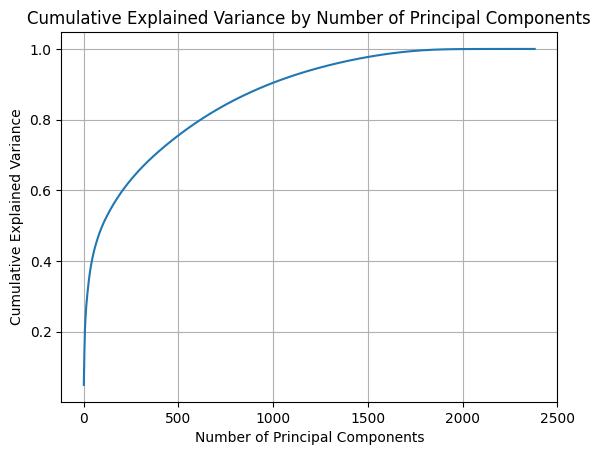

In [ ]:
# Create an instance of PCA
f_pca = PCA()

# Fit PCA on your dataset
f_pca.fit(X_train_norm)

# Transform the dataset using the fitted PCA
X_full_pca = f_pca.transform(X_train_norm)

# Access the explained variance ratio
explained_variance_ratio = f_pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.grid(True)
plt.savefig('cumulative_explained_variance_by_number_of_pcs.png')
plt.show()

In [ ]:
print(f'Cumulative Explained Variance for 600 Principal Components: {cumulative_explained_variance[700]}')
print(f'Cumulative Explained Variance for 700 Principal Components: {cumulative_explained_variance[1000]}')

Cumulative Explained Variance for 600 Principal Components: 0.8274853130352939
Cumulative Explained Variance for 700 Principal Components: 0.9044088057546705


#### Statistics

In [9]:
def get_features_variance(X):
  return np.std(X, axis=0) ** 2


def _calculate_number_of_chunks(num_samples, chunk_size):
  n_chunks = num_samples // chunk_size
  raw_chunks = num_samples / chunk_size

  return n_chunks if n_chunks >= raw_chunks else n_chunks + 1


def get_features_correlation_with_target(X, y, chunk_size=200000):   
  # Calculate the number of chunks
  n_chunks = _calculate_number_of_chunks(X.shape[0], chunk_size)

  # Initialize an empty DataFrame to store correlations
  correlations = pd.DataFrame(index=range(X.shape[1]), columns=["pearson"])

  # Loop through the data in chunks
  for i in range(n_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Load a chunk into memory
    X_chunk = X[start:end, :]
    y_chunk = y[start:end]

    # Calculate Pearson correlation for each feature in the chunk
    for feature in range(X_chunk.shape[1]):
      corr, _ = pearsonr(X_chunk[:, feature], y_chunk)
      if i == 0:
          correlations.loc[feature, "pearson"] = corr
      else:
        correlations.loc[feature, "pearson"] = (correlations.loc[feature, "pearson"] * i + corr) / (i + 1)
  return correlations


def get_features_correlations(X, chunk_size=200000):
  """
     Removes one feature of every pair of features with a correlation greater than the threshold.
  """

  def _compute_features_correlations(X, chunk_size):
    # Calculate the number of chunks
    n_chunks = _calculate_number_of_chunks(X.shape[0], chunk_size)

    # Initialize an empty DataFrame to store feature-feature correlations
    feature_correlations = pd.DataFrame(index=range(X.shape[1]), columns=range(X.shape[1]))

    # Loop through the data in chunks
    for i in range(n_chunks):
      start = i * chunk_size
      end = start + chunk_size

      # Load a chunk into memory
      X_chunk = X[start:end, :]

      # Calculate Pearson correlation for each feature with other features
      for feature1 in range(X_chunk.shape[1]):
        for feature2 in range(feature1+1, X_chunk.shape[1]):
          corr, _ = pearsonr(X_chunk[:, feature1], X_chunk[:, feature2])
          if i == 0:
              feature_correlations.loc[feature1, feature2] = corr
          else:
              feature_correlations.loc[feature1, feature2] = (feature_correlations.loc[feature1, feature2] * i + corr) / (i + 1)

    return feature_correlations

  try:
    corr_features = pd.read_csv(f'{gdrive_data_folder}/fully_corr_features_metrix.csv')
  except FileNotFoundError:
    # If the file doesn't exist, create the correlations 
    corr_features = _compute_features_correlations(X, chunk_size)

  return corr_features

def __get_features_correlations(X, horizontal_chunk_size=700):
  dfX = pd.DataFrame(X_train)
  num_of_features = X_train.shape[1] 
  num_of_chunks = num_of_features // horizontal_chunk_size + 1

  corrs_lst = []

  for i in range(num_of_chunks):
    start = horizontal_chunk_size * i 
    end = min(start + horizontal_chunk_size, num_of_features)
    chunk_df = dfX.iloc[:, start:end]
    chunk_corr = chunk_df.corr()
    corrs_lst.append(chunk_corr)

  return corrs_lst

def __count_high_correlated_features(corrs_lst, th):
  count = 0
  for corr in corrs_lst:
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    # Find features with correlation greater than threshold
    count += len([column for column in upper.columns if any(upper[column] > th)])

  return count

In [10]:
def show_feature_count_vs_thresholds(thresholds, counts, label, width=0.005):
  """
  """
  # Plotting the histogram
  plt.bar(thresholds, counts, width=width, align='edge')
  plt.xlabel(f'{label} Threshold')
  plt.ylabel('Count of Features')
  plt.title(f'Feature Counts vs. {label} <= Threshold')
  plt.grid(True)
  plt.show()

In [11]:
corrs_lst = __get_features_correlations(X_train)

In [ ]:
__count_high_correlated_features(corrs_lst, th=0.9)

848

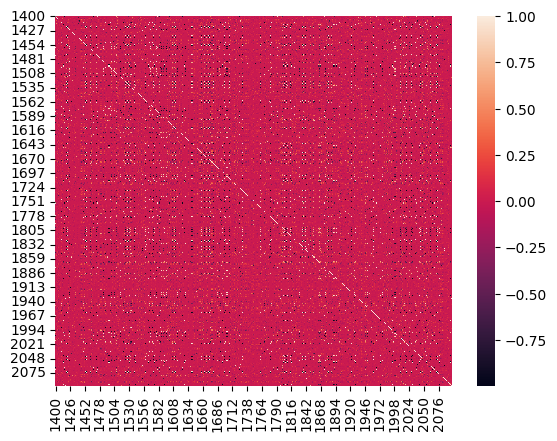

In [ ]:
sns.heatmap(corrs_lst[2])
plt.show()

In [12]:
# Describe features variances
features_variance = get_features_variance(X_train)

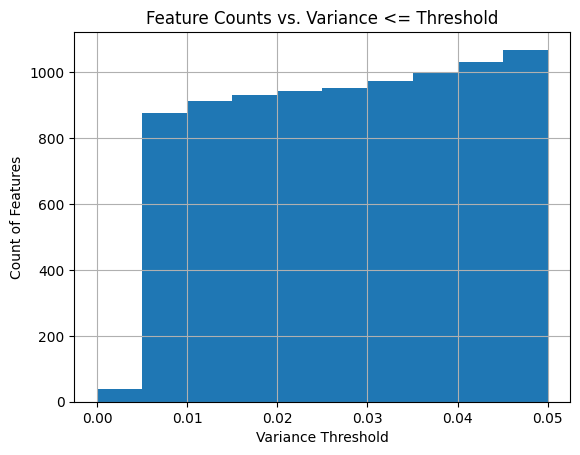

In [ ]:
thresholds = np.arange(0, 0.05, 0.005)  
counts = []

for threshold in thresholds:
    count = (features_variance <= threshold).sum()
    counts.append(count)

show_feature_count_vs_thresholds(thresholds, counts, label='Variance')

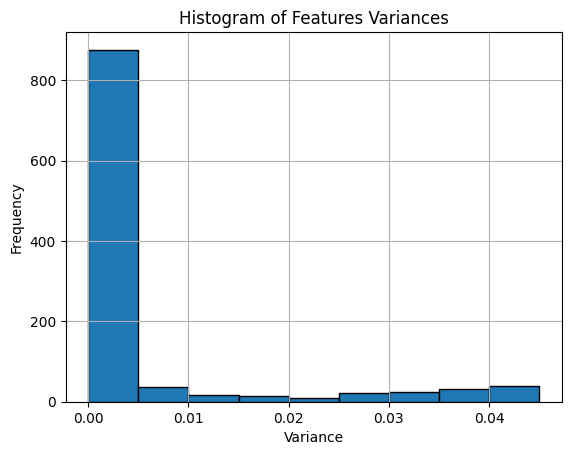

In [ ]:
bins = np.arange(0, 0.05, 0.005)

# create histogram
counts, edges = np.histogram(features_variance, bins)

# plot histogram
plt.hist(features_variance, bins=bins, edgecolor='black')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Features Variances')
plt.grid(True)
plt.show()

In [ ]:
print((features_variance <= 0.01).sum())

913


In [ ]:
print((features_variance <= 0.005).sum())

876


In [13]:
corr_with_target = get_features_correlation_with_target(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
corr_with_target

,pearson
0,-0.156226
1,-0.228933
2,-0.189528
3,-0.091999
4,-0.143231
...,...
2376,0.009504
2377,0.010762
2378,0.012639
2379,0.02057


In [ ]:
asb_corr_with_target_series = corr_with_target['pearson'].abs()  
asb_corr_with_target_series.max()

0.4492349964084439

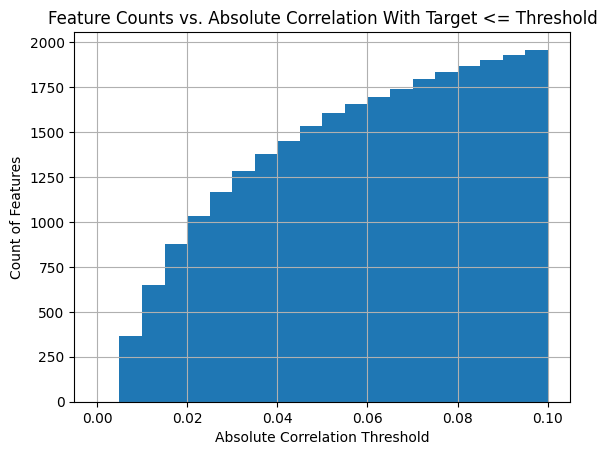

In [ ]:
thresholds = np.arange(0, 0.1, 0.005)
counts = []

for threshold in thresholds:
    count = (asb_corr_with_target_series <= threshold).sum()
    counts.append(count)

show_feature_count_vs_thresholds(thresholds, counts, label='Absolute Correlation With Target')

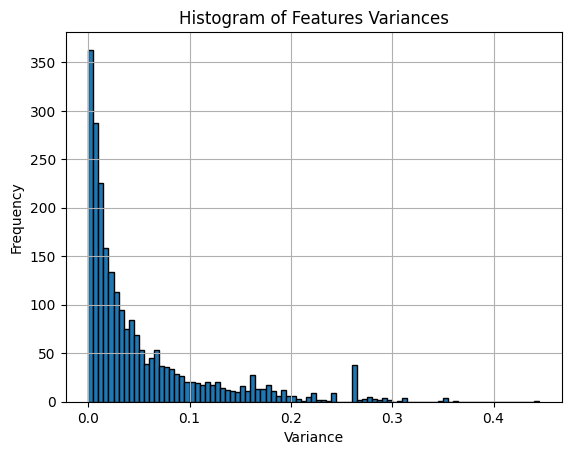

In [ ]:
bins = np.arange(0, 0.45, 0.005)

# create histogram
counts, edges = np.histogram(asb_corr_with_target_series, bins)

# plot histogram
plt.hist(asb_corr_with_target_series, bins=bins, edgecolor='black')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Features Variances')
plt.grid(True)
plt.show()

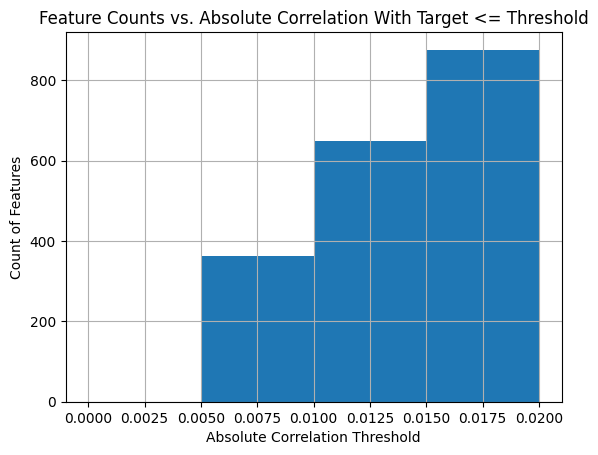

In [ ]:
thresholds = np.arange(0, 0.02, 0.005)
counts = []

for threshold in thresholds:
    count = (asb_corr_with_target_series <= threshold).sum()
    counts.append(count)

show_feature_count_vs_thresholds(thresholds, counts, label='Absolute Correlation with Target')

Upon examining the cumulative variance across our principal components, it becomes evident that approximately 700 components account for roughly 82% of the total variance within our dataset and 1000 CPs account for ~90%. This significant proportion of explained variance solidifies the choice of these 700 or 1000 dimensions as the optimal balance between preserving data integrity and maintaining computational efficiency.

In [ ]:
n_components = 700

In [ ]:
# Save 'X_pca', the reduced-dimension representation of the input data.
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_train_norm)

In [ ]:
def visualize(X, y, title, labels = ['x', 'y'], file_name='figure', to_save=True, grid=True, i=0, j=1):
  plt.scatter(X[y==0, i], X[y==0, j], alpha=0.5, label='Benign', s=2)
  plt.scatter(X[y==1, i], X[y==1, j], alpha=0.5, label='Malicious', s=2)
  plt.legend()
  plt.title(title)
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  plt.grid(grid)
  plt.show()
  if to_save:
    plt.savefig(f'{file_name}.png')

Principal Component Analysis (PCA) Scatter Plot for Malicious and Benign Files

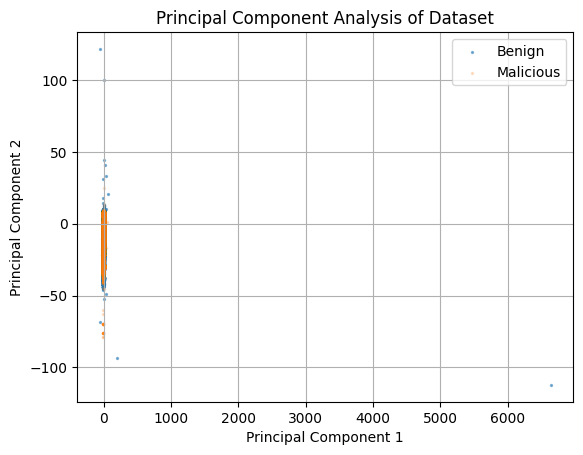

<Figure size 640x480 with 0 Axes>

In [ ]:
visualize(
    X=X_pca,
    y=y_train,
    title='Principal Component Analysis of Dataset',
    labels = ['Principal Component 1', 'Principal Component 2'],
    file_name = 'pca_0_to_1'
)

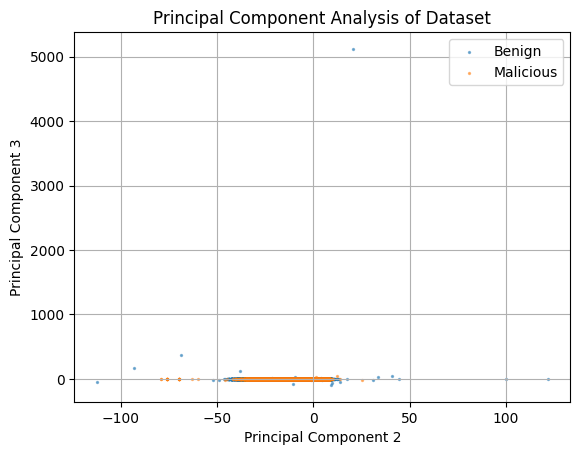

In [ ]:
visualize(
    X=X_pca,
    y=y_train,
    title='Principal Component Analysis of Dataset',
    labels = ['Principal Component 2', 'Principal Component 3'],
    i=1,
    j=2,
)

#### t-SNE Visualization of Malicious and Benign Files

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


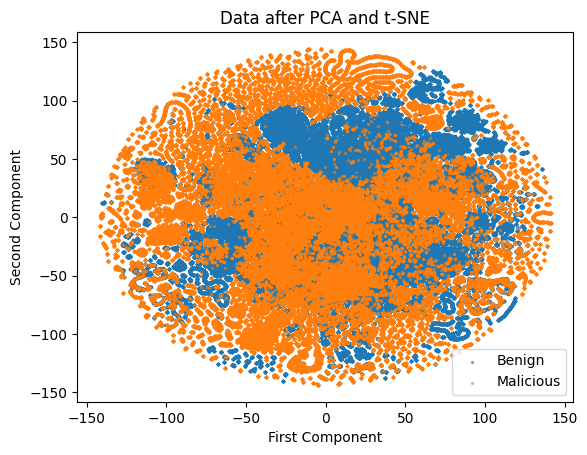

<Figure size 640x480 with 0 Axes>

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)

visualize(
    X=X_tsne,
    y=y_train,
    title='Data after PCA and t-SNE',
    labels = ['First Component', 'Second Component'],
    file_name = 'tNSE'
)

## Evaluation Metrics

In [69]:
def print_result(y_true, y_pred, title):
  print(f'{title}:')
  print()

  # Compute accuracy
  accuracy = accuracy_score(y_true, y_pred)
  print(f'Accuracy: {accuracy:.3f}')

  # Compute confusion matrix
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  # Compute false positive rate (FPR) and true positive rate (TPR)
  fpr = fp / (fp + tn)
  tpr = tp / (tp + fn)

  print(f'False Positive Rate (FPR): {fpr:.5f}')
  print(f'True Positive Rate (TPR): {tpr:.5f}')


  # Compute false negative rate (FNR) and true negative rate (TNR)
  fnr = fn / (fn + tp)
  tnr = tn / (tn + fp)

  print(f'False Negative Rate (FNR): {fnr:.4f}')
  print(f'True Negative Rate (TNR): {tnr:.4f}')


def classify_by_threshold(y_pred_cont, threshold=0.5):
  y_pred = [1 if score > threshold else 0 for score in y_pred_cont]
  return y_pred


def _get_threshold_by_fpr(thresholds, fpr, target_fpr=0.0001):
  # Find the threshold for the FPR closest to the target FPR
  idx = np.argmin(np.abs(fpr - target_fpr))
  threshold_at_target_fpr = thresholds[idx]
  print(f'The threshold that corresponds to FPR={target_fpr} is {threshold_at_target_fpr:.4f}')
  return threshold_at_target_fpr


def _plot_curve(fpr, tpr, target_fpr, label):
  # Find the y-value corresponding to target_fpr
  y_at_target_fpr = np.interp(target_fpr, fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, label=f'{label} \n Score at FPR={target_fpr}: {y_at_target_fpr:.4f}')
  plt.xlim([0.0, 0.001])
  plt.ylim([0.0, 1.05])
  plt.grid(True)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc="lower right")

  # Customizations
  plt.xticks([0, 0.0001, 0.0005, 0.001])  # Set x-axis ticks

  # Draw a horizontal line at the corresponding y-value for x= target_fpr
  plt.axhline(y=y_at_target_fpr, color='g', linestyle='--')
  plt.axvline(x=target_fpr, color='g', linestyle='--') 

  # Show the plot
  plt.show()


def results(y_true, y_pred_prob, label, target_fpr=0.0001, to_plot_curve=True):
  """
    Result:  ROC curve, Accuracy, confusion matrix 

    Returns the prediction created by the threshold for the traget fpr
  """
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
  threshold_at_target_fpr = _get_threshold_by_fpr(thresholds, fpr, target_fpr)
  if to_plot_curve:
    _plot_curve(fpr, tpr, target_fpr, label=f'{label} \n ROC accuracy score: {roc_auc_score(y_true, y_pred_prob):.3f}.')

  # print results in the required fpr
  y_pred_at_th = classify_by_threshold(y_pred_prob, threshold_at_target_fpr) 
  print_result(y_true=y_true, y_pred=y_pred_at_th, title=f'Model Results at threshold={threshold_at_target_fpr:.4f}:')

  return y_pred_at_th

## EMBER Baseline

The threshold that corresponds to FPR=0.0001 is 1.0000


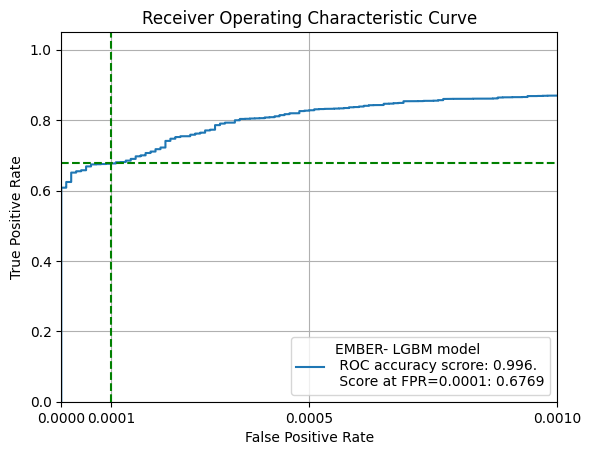

Model Results at threshold=1.0000::

Accuracy: 0.838
False Positive Rate (FPR): 0.00009
True Positive Rate (TPR): 0.67604
False Negative Rate (FNR): 0.3240
True Negative Rate (TNR): 0.9999


In [ ]:
start_time = time.time()
# Evaluate performance
preds = lgbm_model.predict(X_test)
_ = results(y_test, preds, label="EMBER- LGBM model")
end_time = time.time()
lgbm_model_execution_time = end_time - start_time

In [ ]:
print(f"Time for evaluating the test dataset: {lgbm_model_execution_time}")

Time for evaluating the test dataset: 15.69281792640686


In [ ]:
print(f'Number of trees: {lgbm_model.num_trees()}')
print(f"Number of features used by LGBM Model: {lgbm_model.num_feature()}")

In [ ]:
lgbm_model.trees_to_dataframe()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S3,0-S1,None,Column_637,120942.000000,-1.000000e-35,<=,left,None,0.000000,0,600000
1,0,2,0-S3,0-S12,0-S6,0-S0,Column_572,16161.799805,4.589817e-03,<=,left,None,-1.514090,0,156118
2,0,3,0-S12,0-S980,0-S26,0-S3,Column_906,4282.209961,-1.500000e+00,<=,left,None,-1.790820,0,131752
3,0,4,0-S980,0-S1216,0-L981,0-S12,Column_775,12.901500,-7.264360e-01,<=,left,None,1.918900,0,1233
4,0,5,0-S1216,0-L0,0-S1326,0-S980,Column_146,3.566170,5.131880e-04,<=,left,None,1.962680,0,1179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958289,999,6,999-S78,999-L77,999-S397,999-S76,Column_124,0.000786,2.172856e-03,<=,left,None,0.049870,0,611
2958290,999,7,999-L77,None,None,999-S78,None,NaN,NaN,None,None,None,-0.022304,0,219
2958291,999,7,999-S397,999-L79,999-L398,999-S78,Column_459,0.000298,1.519318e-03,<=,left,None,0.432629,0,392
2958292,999,8,999-L79,None,None,999-S397,None,NaN,NaN,None,None,None,0.041579,0,160


### Feature Extraction

Upon out EDA process, we extract features by three categories:
  - Feature Variance
  - Feature correlation with target 
  - Correlation between two features

** Since computing correlations between all the features takes too much time and can't be done by our machine, we split the data into groups and calculate correlations within each group. Clearly, it is less informative, but we find it to be sufficient.

In [15]:
class Features_Extraction_Manager:
  def __init__(self, num_of_features, features_variance, features_correlations_lst, corr_with_target):
    self.selected_features = [True for _ in range(num_of_features)]
    self.initial_num_features = num_of_features

    self.features_variance = features_variance
    self.features_correlations_lst = features_correlations_lst
    self.corr_with_target = corr_with_target

  def extract_by_variance(self, th):
    high_variance_features = self.features_variance > th
    print(f'# extracted by Variance: {self.initial_num_features - np.count_nonzero(high_variance_features)}')
    self.selected_features = np.logical_and(high_variance_features, self.selected_features)
  

  def extract_by_corr_to_target(self, th):
    high_corr_with_target =  self.corr_with_target["pearson"].abs() >= th
    print(f'# extracted by Correlation with target: {self.initial_num_features - np.count_nonzero(high_corr_with_target)}')
    self.selected_features = np.logical_and(high_corr_with_target, self.selected_features)
    

  def _extract_by_corr_df(self, corr, th):
    dropping_count = 0
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    for column in upper.columns:
      if any(upper[column] > th):
        dropping_count += 1
        self.selected_features[column] = False
    
    print(f'# extracted by Correlation between features: {dropping_count}')


  def extract_by_corr_of_features(self, th):
    for corr in self.features_correlations_lst:
      self._extract_by_corr_df(corr, th)

  
  def extract(self, corr_th, variance_th, corr_with_target_th):
    self.extract_by_variance(variance_th)
    self.extract_by_corr_to_target(corr_with_target_th)
    self.extract_by_corr_of_features(corr_th)


  def remove_extracted_features(self, X_train, X_val, X_test):
    return X_train[:, self.selected_features], X_val[:, self.selected_features], X_test[:, self.selected_features]


  def get_selected_fetures(self):
    return self.selected_features

In [16]:
num_of_features = X_train.shape[1]
print(f'# Features in the data: {num_of_features}')

# Features in the data: 2381


In [17]:
feature_manager_1 = Features_Extraction_Manager(num_of_features, features_variance, corrs_lst, corr_with_target)
feature_manager_1.extract(corr_th=0.95, variance_th=0.012, corr_with_target_th=0.005)
X1_train, X1_val, X1_test = feature_manager_1.remove_extracted_features(X_train, X_val, X_test)
print()
print(f'# Features in the data X1: {X1_train.shape[1]}')

# extracted by Variance: 919
# extracted by Correlation with target: 404
# extracted by Correlation between features: 22
# extracted by Correlation between features: 47
# extracted by Correlation between features: 186
# extracted by Correlation between features: 27

# Features in the data X1: 978


In [18]:
feature_manager_1.selected_features

0        True
1       False
2       False
3       False
4       False
        ...  
2376    False
2377    False
2378    False
2379     True
2380    False
Name: pearson, Length: 2381, dtype: bool

In [ ]:
feature_manager_2 = Features_Extraction_Manager(num_of_features, features_variance, corrs_lst, corr_with_target)
feature_manager_2.extract(corr_th=0.9, variance_th=0.005, corr_with_target_th=0.003)
X2_train, X2_val, X2_test = feature_manager_2.remove_extracted_features(X_train, X_val, X_test)
print()
print(f'# Features in the data X2: {X2_train.shape[1]}')

# extracted by Variance: 876
# extracted by Correlation with target: 274
# extracted by Correlation between features: 37
# extracted by Correlation between features: 63
# extracted by Correlation between features: 212
# extracted by Correlation between features: 30

# Features in the data X2: 1060


In [ ]:
feature_manager_3 = Features_Extraction_Manager(num_of_features, features_variance, corrs_lst, corr_with_target)
feature_manager_3.extract(corr_th=0.97, variance_th=0.012, corr_with_target_th=0.004)
X3_train, X3_val, X3_test = feature_manager_3.remove_extracted_features(X_train, X_val, X_test)
print()
print(f'# Features in the data X3: {X3_train.shape[1]}')

# extracted by Variance: 919
# extracted by Correlation with target: 347
# extracted by Correlation between features: 16
# extracted by Correlation between features: 41
# extracted by Correlation between features: 159
# extracted by Correlation between features: 24


## **Models**

Harnessing the power of XGBoost, a gradient-boosted decision tree model, acclaimed for its adeptness at handling high-dimensional data. The rationale behind this choice is its proven track record of high performance, and the inherent efficiency and optimization of the algorithm.

In [ ]:
X1_train = np.load(f'{gdrive_data_folder}/X1_train.npy')
X1_val = np.load(f'{gdrive_data_folder}/X1_val.npy')
X1_test = np.load(f'{gdrive_data_folder}/X1_test.npy')

## **Model 1**

Trying servaral parameters and using 2-3 datasets with different extracted fetures. 

we try grid search once but it required too much resources and do not end the running. Then, we estimate manuualy or using a shrink grid search several times as well.



In [41]:
class XGB_Model:

  def __init__(self, X_train, y_train, X_val, y_val):
    self.X_train = X_train
    self.X_val = X_val

    self.y_train = y_train
    self.y_val = y_val

    self.dtrain = xgb.DMatrix(X_train, label=y_train)
    self.dtest = xgb.DMatrix(X_val, label=y_val)

    self.threshold = None # benign if score < threshold. Otherwise, malicious
    self.model = None


  def fit(self, params, num_rounds):
    self.model = xgb.train(params, self.dtrain, num_rounds, early_stopping_rounds=10, evals=[(self.dtest, 'test')])


  def predict(self, X_new, y_new):
    dnew = xgb.DMatrix(X_new, label=y_new)
    preds_scores = self.model.predict(dnew)
    return preds_scores


  def choose_treshold(self, confidence_offset=0, target_fpr=0.0001):
    """
      Choosing a threshold base on the validation dataset
    """
    if self.model is None:
      raise Exception("You must fit the model before choosing a treshold")

    preds_scores = self.model.predict(self.dtest)
    fpr, tpr, thresholds = roc_curve(self.y_val, preds_scores)
    th_candidate = _get_threshold_by_fpr(thresholds, fpr, target_fpr) + confidence_offset
    self.threshold = min(th_candidate, 1)
  

  def plot_curve(self, y_true, preds_scores, label="XGB", target_fpr=0.0001):
    fpr, tpr, thresholds = roc_curve(y_true, preds_scores)
    _plot_curve(fpr, tpr, target_fpr, label=f'{label} \n ROC accuracy score: {roc_auc_score(y_true, preds_scores):.3f}.')


  def print_results(self, y_true, preds_scores):
    if self.threshold is None:
      raise Exception("You must chose a threshold for the model to get results")

    # print results in the required fpr
    y_pred_at_th = classify_by_threshold(preds_scores, self.threshold) 
    print_result(y_true=y_true, y_pred=y_pred_at_th, title=f'Model Results at threshold={self.threshold:.4f}:')


  def results(self, y_true, preds_scores, label="XGB", target_fpr=0.0001):
    self.plot_curve(y_true, preds_scores, label, target_fpr)
    self.print_results(y_true, preds_scores)

  def evaluate(self, X_new, y_new, to_plot_curve=True):
    preds = self.predict(X_new, y_new)
    predictions = results(y_new, preds, label = f'XGBoost Model', to_plot_curve=to_plot_curve)

    return predictions

In [21]:
m1 = XGB_Model(X1_train, y_train, X1_val, y_val)
params = {
    'max_depth': 13,  # maximum depth of each tree
    'eta': 0.3,  # learning_rate
    'objective': 'binary:logistic',  
    'num_class': 1 
} 
m1.fit(params, num_rounds=300)

[0]	test-logloss:0.50645
[1]	test-logloss:0.38973
[2]	test-logloss:0.31431
[3]	test-logloss:0.26013
[4]	test-logloss:0.21679
[5]	test-logloss:0.18893
[6]	test-logloss:0.16709
[7]	test-logloss:0.15032
[8]	test-logloss:0.13822
[9]	test-logloss:0.12912
[10]	test-logloss:0.12042
[11]	test-logloss:0.11570
[12]	test-logloss:0.11216
[13]	test-logloss:0.10713
[14]	test-logloss:0.10154
[15]	test-logloss:0.09846
[16]	test-logloss:0.09539
[17]	test-logloss:0.09377
[18]	test-logloss:0.09073
[19]	test-logloss:0.08906
[20]	test-logloss:0.08794
[21]	test-logloss:0.08658
[22]	test-logloss:0.08517
[23]	test-logloss:0.08273
[24]	test-logloss:0.08120
[25]	test-logloss:0.08062
[26]	test-logloss:0.08021
[27]	test-logloss:0.07807
[28]	test-logloss:0.07722
[29]	test-logloss:0.07613
[30]	test-logloss:0.07559
[31]	test-logloss:0.07476
[32]	test-logloss:0.07368
[33]	test-logloss:0.07335
[34]	test-logloss:0.07297
[35]	test-logloss:0.07242
[36]	test-logloss:0.07176
[37]	test-logloss:0.07129
[38]	test-logloss:0.07

In [ ]:
m1 = XGB_Model(X1_train, y_train, X1_val, y_val)
params = {
    'max_depth': 13,  # maximum depth of each tree
    'eta': 0.3,  # learning_rate
    'objective': 'binary:logistic',  
    'num_class': 1 
} 
m1.fit(params, num_rounds=300)

[0]	test-logloss:0.50645
[1]	test-logloss:0.38973
[2]	test-logloss:0.31431
[3]	test-logloss:0.26013
[4]	test-logloss:0.21679
[5]	test-logloss:0.18893
[6]	test-logloss:0.16709
[7]	test-logloss:0.15032
[8]	test-logloss:0.13822
[9]	test-logloss:0.12912
[10]	test-logloss:0.12042
[11]	test-logloss:0.11570
[12]	test-logloss:0.11216
[13]	test-logloss:0.10713
[14]	test-logloss:0.10154
[15]	test-logloss:0.09846
[16]	test-logloss:0.09539
[17]	test-logloss:0.09377
[18]	test-logloss:0.09073
[19]	test-logloss:0.08906
[20]	test-logloss:0.08794
[21]	test-logloss:0.08658
[22]	test-logloss:0.08517
[23]	test-logloss:0.08273
[24]	test-logloss:0.08120
[25]	test-logloss:0.08062
[26]	test-logloss:0.08021
[27]	test-logloss:0.07807
[28]	test-logloss:0.07722
[29]	test-logloss:0.07613
[30]	test-logloss:0.07559
[31]	test-logloss:0.07476
[32]	test-logloss:0.07368
[33]	test-logloss:0.07335
[34]	test-logloss:0.07297
[35]	test-logloss:0.07242
[36]	test-logloss:0.07176
[37]	test-logloss:0.07129
[38]	test-logloss:0.07

The threshold that corresponds to FPR=0.0001 is 0.9985


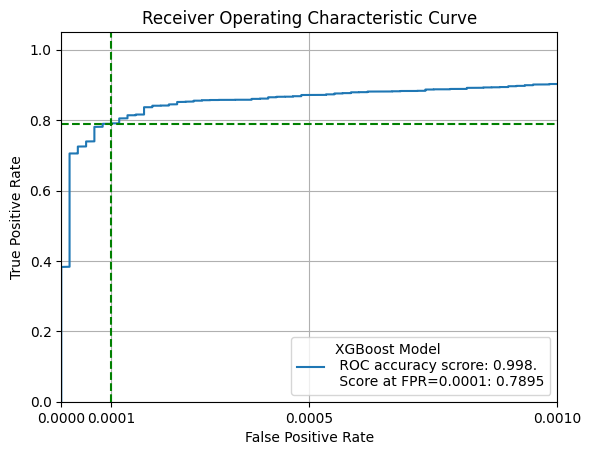

Model Results at threshold=0.9985::

Accuracy: 0.895
False Positive Rate (FPR): 0.00008
True Positive Rate (TPR): 0.78948
False Negative Rate (FNR): 0.2105
True Negative Rate (TNR): 0.9999


In [ ]:
m1.evaluate(X1_val, y_val)

The threshold that corresponds to FPR=0.0001 is 0.9993


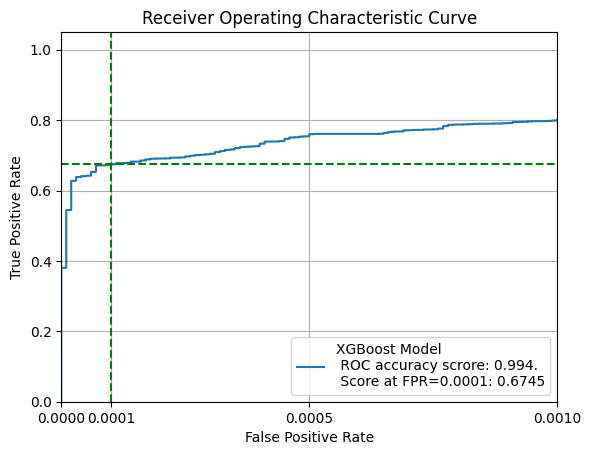

Model Results at threshold=0.9993::

Accuracy: 0.836
False Positive Rate (FPR): 0.00009
True Positive Rate (TPR): 0.67226
False Negative Rate (FNR): 0.3277
True Negative Rate (TNR): 0.9999


In [ ]:
m1.evaluate(X1_test, y_test)

In [ ]:
m1_1 = XGB_Model(X1_train, y_train, X1_val, y_val)
# Set the parameters for the xgboost
params1_1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',  
    'num_class': 1 
} 

m1.fit(params1_1, num_rounds=800)

In [ ]:
m1_1.evaluate(X1_val, y_val)

In [ ]:
m2 = XGB_Model(X2_train, y_train, X2_val, y_val)
params2 = {
    'max_depth': 14,  # maximum depth of each tree
    'eta': 0.4,  # learning_rate
    'objective': 'binary:logistic',  
    'num_class': 1 
} 
m2.fit(params2, num_rounds=250)

[0]	test-logloss:0.44661
[1]	test-logloss:0.31850
[2]	test-logloss:0.23801
[3]	test-logloss:0.18946
[4]	test-logloss:0.15857
[5]	test-logloss:0.13501
[6]	test-logloss:0.12008
[7]	test-logloss:0.11246
[8]	test-logloss:0.10558
[9]	test-logloss:0.09916
[10]	test-logloss:0.09507
[11]	test-logloss:0.09133
[12]	test-logloss:0.08845
[13]	test-logloss:0.08450
[14]	test-logloss:0.08315
[15]	test-logloss:0.08131
[16]	test-logloss:0.07999
[17]	test-logloss:0.07869
[18]	test-logloss:0.07555
[19]	test-logloss:0.07460
[20]	test-logloss:0.07299
[21]	test-logloss:0.07218
[22]	test-logloss:0.07168
[23]	test-logloss:0.07092
[24]	test-logloss:0.07023
[25]	test-logloss:0.06938
[26]	test-logloss:0.06912
[27]	test-logloss:0.06871
[28]	test-logloss:0.06835
[29]	test-logloss:0.06752
[30]	test-logloss:0.06667
[31]	test-logloss:0.06538
[32]	test-logloss:0.06499
[33]	test-logloss:0.06381
[34]	test-logloss:0.06321
[35]	test-logloss:0.06310
[36]	test-logloss:0.06244
[37]	test-logloss:0.06228
[38]	test-logloss:0.06

The threshold that corresponds to FPR=0.0001 is 0.9991


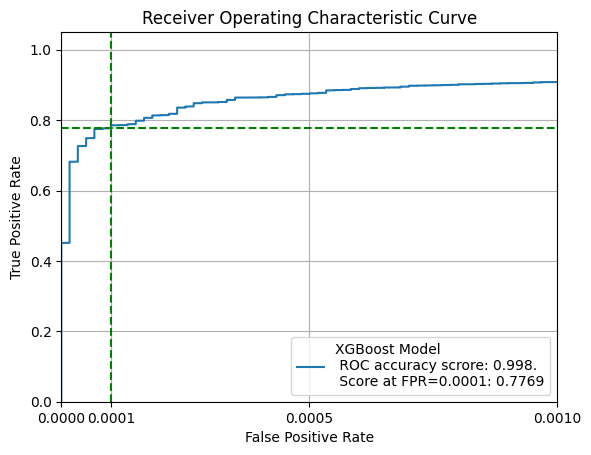

Model Results at threshold=0.9991::

Accuracy: 0.888
False Positive Rate (FPR): 0.00008
True Positive Rate (TPR): 0.77676
False Negative Rate (FNR): 0.2232
True Negative Rate (TNR): 0.9999


In [ ]:
m2.evaluate(X2_val, y_val)

In [ ]:
m3 = XGB_Model(X3_train, y_train, X3_val, y_val)
params3 = {
    'max_depth': 13,  # maximum depth of each tree
    'eta': 0.3,  # learning_rate
    'objective': 'binary:logistic',  
    'num_class': 1 
} 
m3.fit(params3, num_rounds=250)

[0]	test-logloss:0.50578
[1]	test-logloss:0.38842
[2]	test-logloss:0.30653
[3]	test-logloss:0.24997
[4]	test-logloss:0.21164
[5]	test-logloss:0.18419
[6]	test-logloss:0.16384
[7]	test-logloss:0.14843
[8]	test-logloss:0.13681
[9]	test-logloss:0.12989
[10]	test-logloss:0.12133
[11]	test-logloss:0.11573
[12]	test-logloss:0.11092
[13]	test-logloss:0.10818
[14]	test-logloss:0.10409
[15]	test-logloss:0.10216
[16]	test-logloss:0.09975
[17]	test-logloss:0.09670
[18]	test-logloss:0.09306
[19]	test-logloss:0.09170
[20]	test-logloss:0.08998
[21]	test-logloss:0.08872
[22]	test-logloss:0.08714
[23]	test-logloss:0.08536
[24]	test-logloss:0.08455
[25]	test-logloss:0.08359
[26]	test-logloss:0.08078
[27]	test-logloss:0.08034
[28]	test-logloss:0.07920
[29]	test-logloss:0.07811
[30]	test-logloss:0.07694
[31]	test-logloss:0.07657
[32]	test-logloss:0.07605
[33]	test-logloss:0.07446
[34]	test-logloss:0.07417
[35]	test-logloss:0.07382
[36]	test-logloss:0.07263
[37]	test-logloss:0.07244
[38]	test-logloss:0.07

The threshold that corresponds to FPR=0.0001 is 0.9976


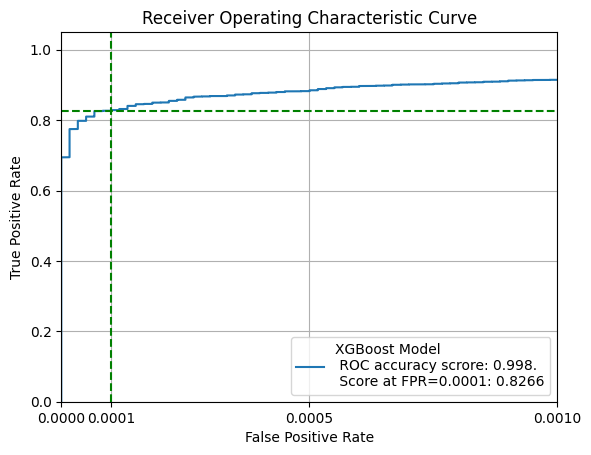

Model Results at threshold=0.9976::

Accuracy: 0.913
False Positive Rate (FPR): 0.00008
True Positive Rate (TPR): 0.82661
False Negative Rate (FNR): 0.1734
True Negative Rate (TNR): 0.9999


In [ ]:
m3.evaluate(X3_val, y_val)

In [ ]:
class GridSearch_Model:
  def __init__(self, X_train, y_train, X_val, y_val):
    self.X_train = X_train
    self.X_val = X_val

    self.y_train = y_train
    self.y_val = X_val

    self.grid_search = None
    self.best_model = None
    self.estimator = xgb.XGBClassifier(objective='binary:logistic', num_class=1, tree_method='gpu_hist')


  def get_best_model(self):
    return self.best_model


  def get_params_of_best_model(self):
    if self.best_model is None:
      return None

    return self.best_model.get_params()


  def fit(self, params):
    self.grid_search = GridSearchCV(estimator=self.estimator, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)
    self.grid_search.fit(self.X_train, self.y_train)
    self.best_model = self.grid_search.best_estimator_


  def predict(self, X_new):
    return self.model.predict(X_new)


  def evaluate(self, X_new, y_new, to_plot_curve=True):
    preds = self.predict(X_new)
    _ = results(y_new, preds, label = 'GridSearch Best Model', to_plot_curve=to_plot_curve)

In [ ]:
gs_model1 = GridSearch_Model(X_train, y_train, X_val, y_val)

In [ ]:
params_grid = {
    'max_depth': [8, 10, 13],  
    'learning_rate': [0.3, 0.4],  
    'n_estimators': [200, 400, 800]
}

gs_model1.fit(params_grid)

## **Model 2**

First, we'll attempt to utilize 700 components that cover ~82% of the variance of the training dataset.

Then, we may try 1000 principal components that cover ~90% of the variance of the training dataset.

Eventually, we decide to employ the standard XGBoost instead of the grid search method. This decision is made after training the first model, when we realize that our computational resources are not sufficient to manage the task efficiently. As a result, we opt to examine the hyperparameters manually.

In [ ]:
class PCA_Model:

  def __init__(self, X_train, X_val, y_train, y_val, n_components):
    self.scaler = StandardScaler()
    X_train_norm = self.scaler.fit_transform(X_train)

    self.n = n_components
    self.pca = PCA(n_components=n_components, random_state=42)

    pca_X = self.pca.fit_transform(X_train_norm)
    self.X_tarin = xgb.DMatrix(pca_X, label=y_train)
    self.X_val = self._convert_to_dpca(X_val, y_val)

    self.y_train = y_train
    self.y_val = y_val

    self.model = None

  def _convert_to_dpca(self, X, y):
    norm_X =  self.scaler.transform(X)
    pca_X = self.pca.transform(norm_X)
    return xgb.DMatrix(pca_X, label=y)

  def fit(self, params, num_rounds):
    """
      Train XGBoost model with the given parametrs and early stopping rounds.
    """
    self.model = xgb.train(params, self.X_tarin, num_rounds, early_stopping_rounds=10, evals=[(self.X_val, 'test')])


  def evaluate(self, X, y):
    dnew = self._convert_to_dpca(X, y)
    preds = self.model.predict(dnew)

    _ = results(y, preds, f"PCA {self.n}:", target_fpr=0.0001)

In [ ]:
pca_700_model = PCA_Model(X_train, X_val, y_train, y_val, n_components=700)

In [ ]:
params = {
    'max_depth': 10,
    'eta': 0.3, # learning rate
    'objective': 'binary:logistic',
    'num_class': 1
} 

pca_700_model.fit(params, num_rounds=400)

[0]	test-logloss:0.52707
[1]	test-logloss:0.42958
[2]	test-logloss:0.36554
[3]	test-logloss:0.31843
[4]	test-logloss:0.28435
[5]	test-logloss:0.25886
[6]	test-logloss:0.23818
[7]	test-logloss:0.22140
[8]	test-logloss:0.20956
[9]	test-logloss:0.19959
[10]	test-logloss:0.19003
[11]	test-logloss:0.18236
[12]	test-logloss:0.17397
[13]	test-logloss:0.16923
[14]	test-logloss:0.16434
[15]	test-logloss:0.15973
[16]	test-logloss:0.15571
[17]	test-logloss:0.15233
[18]	test-logloss:0.14980
[19]	test-logloss:0.14638
[20]	test-logloss:0.14323
[21]	test-logloss:0.14060
[22]	test-logloss:0.13856
[23]	test-logloss:0.13665
[24]	test-logloss:0.13443
[25]	test-logloss:0.13269
[26]	test-logloss:0.13094
[27]	test-logloss:0.12932
[28]	test-logloss:0.12718
[29]	test-logloss:0.12555
[30]	test-logloss:0.12489
[31]	test-logloss:0.12365
[32]	test-logloss:0.12202
[33]	test-logloss:0.12092
[34]	test-logloss:0.11981
[35]	test-logloss:0.11890
[36]	test-logloss:0.11800
[37]	test-logloss:0.11699
[38]	test-logloss:0.11

Try 1000 PCs that are cover roughly 90% of the data set variance

In [ ]:
pca_1000_model = PCA_Model(X_train, X_val, y_train, y_val, n_components=1000)

In [ ]:
params = {
    'max_depth': 14,
    'eta': 0.3, # learning rate
    'objective': 'binary:logistic',
    'num_class': 1
} 

pca_1000_model.fit(params, num_rounds=250)

[0]	test-logloss:0.50371
[1]	test-logloss:0.39272
[2]	test-logloss:0.32063
[3]	test-logloss:0.27032
[4]	test-logloss:0.23478
[5]	test-logloss:0.20856
[6]	test-logloss:0.18817
[7]	test-logloss:0.17396
[8]	test-logloss:0.16242
[9]	test-logloss:0.15305
[10]	test-logloss:0.14554
[11]	test-logloss:0.13971
[12]	test-logloss:0.13436
[13]	test-logloss:0.13051
[14]	test-logloss:0.12743
[15]	test-logloss:0.12414
[16]	test-logloss:0.12156
[17]	test-logloss:0.11986
[18]	test-logloss:0.11738
[19]	test-logloss:0.11574
[20]	test-logloss:0.11390
[21]	test-logloss:0.11235
[22]	test-logloss:0.11124
[23]	test-logloss:0.11005
[24]	test-logloss:0.10902
[25]	test-logloss:0.10803
[26]	test-logloss:0.10765
[27]	test-logloss:0.10704
[28]	test-logloss:0.10672
[29]	test-logloss:0.10634
[30]	test-logloss:0.10594
[31]	test-logloss:0.10538
[32]	test-logloss:0.10506
[33]	test-logloss:0.10484
[34]	test-logloss:0.10450
[35]	test-logloss:0.10418
[36]	test-logloss:0.10382
[37]	test-logloss:0.10362
[38]	test-logloss:0.10

The threshold that corresponds to FPR=0.0001 is 0.999


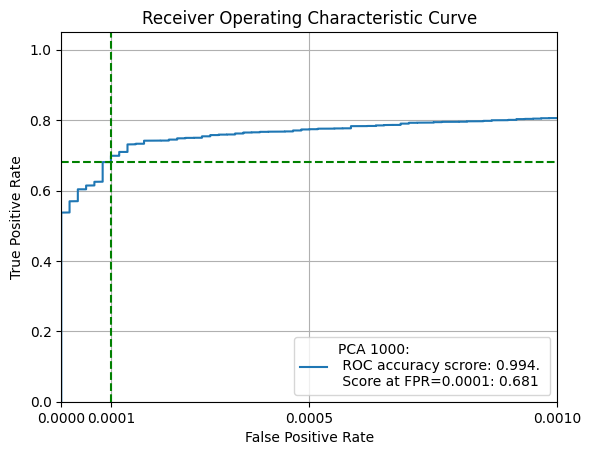

Model Results at threshold=0.999::

Accuracy: 0.840
False Positive Rate (FPR): 0.000
True Positive Rate (TPR): 0.681
False Negative Rate (FNR): 0.319
True Negative Rate (TNR): 1.000


In [ ]:
pca_1000_model.evaluate(X_val, y_val)

The threshold that corresponds to FPR=0.0001 is 0.999


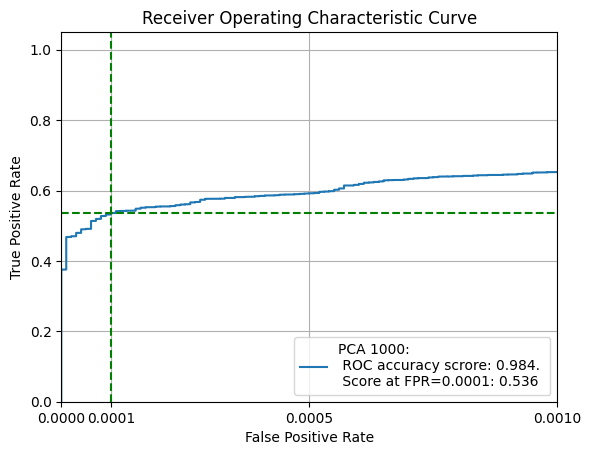

Model Results at threshold=0.999::

Accuracy: 0.766
False Positive Rate (FPR): 0.000
True Positive Rate (TPR): 0.532
False Negative Rate (FNR): 0.468
True Negative Rate (TNR): 1.000


In [ ]:
dnew = pca_1000_model._convert_to_dpca(X_test, y_test)
preds = pca_1000_model.model.predict(dnew)

_ = results(y_test, preds, f"PCA 1000:", target_fpr=0.0001)

## Select the best model 

In [22]:
selected_ml_model = m1

In [49]:
selected_ml_model.choose_treshold(confidence_offset=0.0005)

The threshold that corresponds to FPR=0.0001 is 0.9985


In [50]:
preds = selected_ml_model.predict(X1_test, y_test)

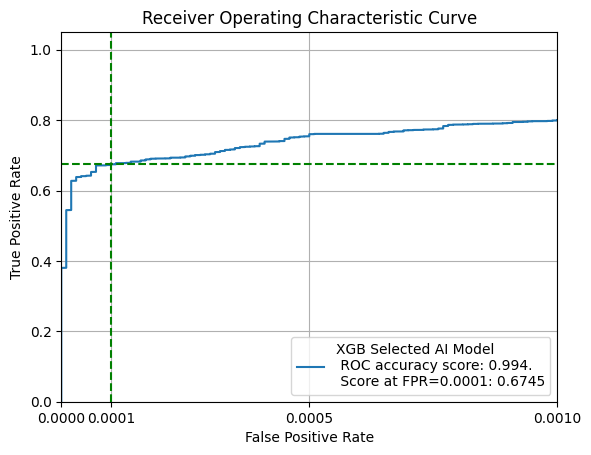

Model Results at threshold=0.9993::

Accuracy: 0.836
False Positive Rate (FPR): 0.00009
True Positive Rate (TPR): 0.67225
False Negative Rate (FNR): 0.3277
True Negative Rate (TNR): 0.9999


In [51]:
selected_ml_model.results(y_test, preds, label="XGB Selected AI Model")

### Evaluating Performance Robustness ###

In this section, we aim to evaluate the performance of our model on datasets that simulate real-world class distributions, as they are often not evenly split (50/50). By considering class separations that are more representative of real-world scenarios, we can gain insights into how our model performs in practical settings.

To achieve this, we create datasets with unequal class proportions, such as 20/80 or 10/90 splits, to mimic imbalanced class distributions commonly encountered in real-world data.

We explore alternative data separation strategies or consider using different models that can be trained on similar data proportions. By doing so, we aim to uncover approaches that are better suited for real-world conditions and have the potential to enhance the model's predictive capabilities.

Interestingly, during our experimentation, we observed that the model exhibits robustness and consistently delivers improved results when the data separation is aligned with real-world scenarios.


In [52]:
def _print_separation_proportion(y_adjusted):
  _, (num_benigns, num_malicious) = np.unique(y_adjusted, return_counts = True)
  num_samples = num_malicious + num_benigns
  proportion = num_malicious / num_samples
  print(f'#samples: {num_samples}')
  print(f'#benign: {num_benigns}')
  print(f'#malicious: {num_malicious}')
  print(f'proportion: {proportion:.3f}')


def adjust_malicious_proportion(X, y, malicious_proportion):
  malicous_val_indices = np.where(y == 1)[0]
  num_malicous_val_adjusted = int(malicious_proportion * len(malicous_val_indices))
  selected_malicous_indices = np.random.choice(malicous_val_indices, size=num_malicous_val_adjusted, replace=False)

  X_adjusted = np.concatenate((X[selected_malicous_indices], X[y != 1]), axis=0)
  y_adjusted = np.concatenate((y[selected_malicous_indices], y[y != 1]), axis=0)

  _print_separation_proportion(y_adjusted)

  return X_adjusted, y_adjusted

1

In [ ]:
X_adjusted_val, y_adjusted_val = adjust_malicious_proportion(X1_val, y_val, malicious_proportion=0.3)

#samples: 77950
#benign: 59929
#malicious: 18021
proportion: 0.231


The threshold that corresponds to FPR=0.0001 is 0.9985


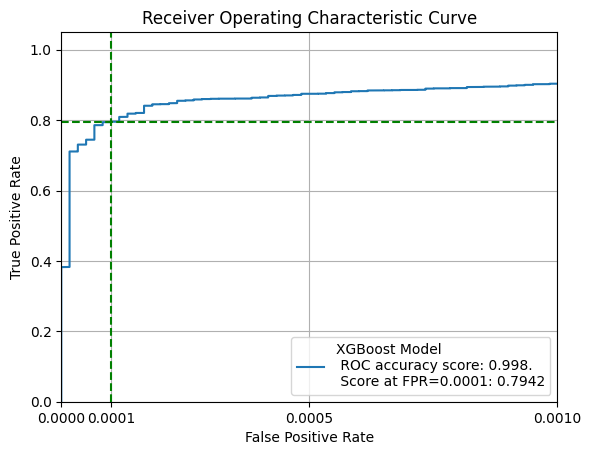

Model Results at threshold=0.9985::

Accuracy: 0.952
False Positive Rate (FPR): 0.00008
True Positive Rate (TPR): 0.79418
False Negative Rate (FNR): 0.2058
True Negative Rate (TNR): 0.9999


In [ ]:
_ = selected_ml_model.evaluate(X_adjusted_val, y_adjusted_val)

2

In [ ]:
X_adjusted_val, y_adjusted_val = adjust_malicious_proportion(X1_val, y_val, malicious_proportion=0.1)

#samples: 65936
#benign: 59929
#malicious: 6007
proportion: 0.091


The threshold that corresponds to FPR=0.0001 is 0.9985


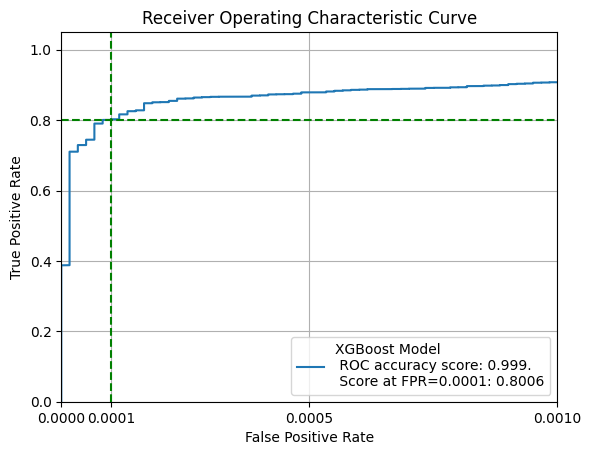

Model Results at threshold=0.9985::

Accuracy: 0.982
False Positive Rate (FPR): 0.00008
True Positive Rate (TPR): 0.80057
False Negative Rate (FNR): 0.1994
True Negative Rate (TNR): 0.9999


In [ ]:
_ = selected_ml_model.evaluate(X_adjusted_val, y_adjusted_val)

## **PDS**

First, we will create our Probabilistic Data Structure that mapping th SHA256 codes to mlicious or binain such that: \
1. Each Malicious file is mapped as mlicious. \
    **FNR(False Negative Rate)=0**
2. The number of binain files that are mapped as malicious is less than 0.01% from the number of all files. \
    **FPR(False Positive Rate)<=0.01%**

#### **Bloom Filter**

We are using the Bloom FIlter Data Structure for checking the exsiting of a malicious file in efficiet way. 

A Bloom filter is a probabilistic data structure that is used to efficiently test whether an element is a member of a set. It uses a bit array and a set of hash functions to represent the set of elements and to determine whether an element is likely to be a member of the set.

Bloom filters have several advantages over other data structures such as hash tables or binary search trees. \
- They are very space-efficient, requiring only a small amount of memory to store the bit array and hash functions.\
- They are very fast, with constant-time insertions and lookups. 
- They can handle large sets of elements with a low probability of false positives.

Bloom filters are particularly useful in cases where the cost of false positives is low (i.e., it is acceptable to occasionally say that a file is a malicous while is not), but the cost of false negatives is high (i.e., it is not acceptable to miss a malicous file).

In [53]:
class Bloom_Filter:
    def __init__(self, n, fpr):
        """
        Inputs:
         n - number of elements that might be inserted to the bloom filter
         fpr - the required False Positive Rate
        """
        bitarry_size, hash_count = self.find_optimal_size(n, fpr)
        self.n = n
        self.bit_size = bitarry_size
        self.hash_count = hash_count
        self.bitarray = bitarray.bitarray(bitarry_size)
        self.bitarray.setall(0)

    def add(self, item):
        for i in range(self.hash_count):
            digest = hashlib.sha256(str(item).encode('utf-8') + str(i).encode('utf-8')).hexdigest()
            index = int(digest, 16) % self.bit_size
            self.bitarray[index] = 1
    
    def remove(self, item):
        for i in range(self.hash_count):
            digest = hashlib.sha256(str(item).encode('utf-8') + str(i).encode('utf-8')).hexdigest()
            index = int(digest, 16) % self.bit_size
            self.bitarray[index] = 0


    def __contains__(self, item):
        for i in range(self.hash_count):
            digest = hashlib.sha256(str(item).encode('utf-8') + str(i).encode('utf-8')).hexdigest()
            index = int(digest, 16) % self.bit_size
            if not self.bitarray[index]:
                return False
        return True


    def get_size(self):
      return self.bit_size


    def get_megabytes_size(self):
      # bits to megabytes
      # (8 - bit to bytes) * (1024 - bytes to kilobytes) * (1024 - kilobytes to megabytes) 
      mb = self.bit_size / (8 * 1024 * 1024)
      return mb


    def get_hash_count(self):
      return self.hash_count


    def find_optimal_size(self, n, fpr):
        """
        The find_optimal_size function compute the optimal size of a bit-array 
        and the number of hash functions needed for a Bloom filter that will store n items with a desired false positive rate of fpr.
        """
        bitarray_size = int(-1 * ((n * np.log(fpr)) / (np.log(2) ** 2))) + 1
        number_of_hash_functions = int((bitarray_size / n) * math.log(2))
        return bitarray_size, number_of_hash_functions


    def __str__(self):
      return f"""
        Bloom filter array (bit) size: {self.bit_size}
        Bloom filter MG size: {self.get_megabytes_size():.3f}
        False Positive Rate: {((1 - math.exp(-self.hash_count * self.n/ self.bit_size)) ** self.hash_count):.5}
        Number of Hash functions: {self.hash_count}
      """

## Malicous SHA256 for EMBER

Update the bloom filter with malicious files and test it.

Due to an issue with the given text, I extracted the hash codes myself.

In [137]:
def get_df_hashes(df):
  hashes = df['sha256']
  return np.array(list(hashes))

# Get the train malicious hash codes
train_df = dataset_df[dataset_df['subset'] == 'train']
mal_train_df = train_df[train_df['label'] == 1]
train_mal_hashes = get_df_hashes(mal_train_df)

# Get the test hash codes
test_df = dataset_df[dataset_df['subset'] == 'test']
test_hashes = get_df_hashes(test_df)

emeber_mal_df = dataset_df[dataset_df['label'] == 1]
ember_mal_hashes = get_df_hashes(emeber_mal_df)

In [ ]:
fpr = 0.0001
n = len(train_mal_hashes)
bf = Bloom_Filter(n, fpr)
for hash in train_mal_hashes:
  bf.add(hash)

from text:

In [ ]:
# Define the bloom filter
fpr = 0.00001
n = 300000
bloom_filter = Bloom_Filter(n, fpr)

In [ ]:
# Add the sha256
test_hash_codes = []
with open(path2malicious_sha256_ember, 'r') as f:
  start_time = time.time()
  for i, hash_code_line in enumerate(f):
    hash_code = hash_code_line[:-1] # without the new line seperator
    bloom_filter.add(hash_code)
  end_time = time.time()
  print(bloom_filter)   

bloom_filter_adding_time = end_time - start_time    


        Bloom filter array (bit) size: 7188794
        Bloom filter MG size: 0.857
        False Positive Rate: 1.0049e-05
        Number of Hash functions: 16
      


## Naive Model

In [65]:
class Naive_Learned_Bloom_filter:
  """
    Save all the know malicious in the bloom filter.
    Full back up.

    IMPORTANT: Assuming that the AI model is trained and has a selected threshold.
  """
  def __init__(self, ai_model):
    self.model = ai_model
    self.bloom_filter = None

  
  def fit_bloom_filter(self, malicious_sha256, fpr=0.00001):
    self.bloom_filter = Bloom_Filter(len(malicious_sha256), fpr)
    for hash_code in malicious_sha256:
        self.bloom_filter.add(hash_code)


  def evaluate(self, X_test, y_test, test_hash_codes):
    
    preds_scores = self.model.predict(X_test, y_test)
    predictions = classify_by_threshold(preds_scores, self.model.threshold)
    predictions = np.array(predictions)
    propogate_to_pds = np.where(predictions == 0)[0]
    num_of_correct_fixes = 0
    for sample_index in propogate_to_pds:
      hash = test_hash_codes[sample_index]
      if hash in self.bloom_filter:
        predictions[sample_index] = 1
        if y_test[sample_index] == 1:
          num_of_correct_fixes += 1

    print()
    print("Learn Bloom Filter Results:")
    print()
    print(f'# correct fixes: {num_of_correct_fixes}')
    print_result(y_test, predictions, 'Bloom Filter Results')

In [74]:
# Naive Model
naive_lbf = Naive_Learned_Bloom_filter(selected_ml_model)
naive_lbf.fit_bloom_filter(ember_mal_hashes)

In [76]:
start_time = time.time()

naive_lbf.evaluate(X1_test, y_test, test_hashes)

end_time = time.time()
naive_lbf_execution_time = end_time - start_time

print()
print(f"Time for evaluating the test dataset: {naive_lbf_execution_time}")

[     1      3      4 ... 199994 199997 199998]

Learn Bloom Filter Results:

# correct fixes: 32775
Bloom Filter Results:

Accuracy: 1.000
False Positive Rate (FPR): 0.00009
True Positive Rate (TPR): 1.00000
False Negative Rate (FNR): 0.0000
True Negative Rate (TNR): 0.9999

Time for evaluating the test dataset: 5.21045184135437



## Suggested Model

In [134]:
assert X_full_train.shape == (600000, 2381)
assert X1_test.shape == (200000, 978)

assert y_full_train.shape == (600000,)
assert y_test.shape == (200000,)

In [135]:
# Adjust the dataset

selected_model_features = feature_manager_1.selected_features
X = X_full_train[:, selected_model_features]
ember_dataset = np.concatenate((X, X1_test), axis=0)

labels = np.concatenate((y_full_train, y_test), axis=0)

In [136]:
assert ember_dataset.shape == (800000, 978)
assert dataset_df.shape == (800000, 5)
assert labels.shape == (800000,)

In [141]:
class Suggested_Learned_Bloom_filter:
  """
  Add only the problematic malicious samples.

  IMPORTANT: Assuming that the AI model is trained and has a selected threshold.
  """
  def __init__(self, ai_model):
    self.model = ai_model
    self.bloom_filter = None

  def fit_bloom_filter(self, X, y, df, fpr=0.0001):
    preds_scores = self.model.predict(X, y)
    predictions = classify_by_threshold(preds_scores, self.model.threshold)
    predictions = np.array(predictions)

    # False Negative - true: malicious BUT pred: benign
    fn_indices = np.where((y == 1) & (predictions != y))
    fn_indices = fn_indices[0]
    fn_df = df.iloc[fn_indices, :]
    fn_hashes = get_df_hashes(fn_df)
    num_of_malicioius = len(fn_hashes)
    print(f'size = {num_of_malicioius}')

    self.bloom_filter = Bloom_Filter(num_of_malicioius, fpr)
    for hash_code in fn_hashes:
      self.bloom_filter.add(hash_code)


  def evaluate(self, X_test, y_test, test_hash_codes):
    
    preds_scores = self.model.predict(X_test, y_test)
    predictions = classify_by_threshold(preds_scores, self.model.threshold)
    predictions = np.array(predictions)
    propogate_to_pds = np.where(predictions == 0)[0]
    num_of_correct_fixes = 0
    for sample_index in propogate_to_pds:
      hash = test_hash_codes[sample_index]
      if hash in self.bloom_filter:
        predictions[sample_index] = 1
        if y_test[sample_index] == 1:
          num_of_correct_fixes += 1

    print()
    print("Learn Bloom Filter Results:")
    print()
    print(f'# correct fixes: {num_of_correct_fixes}')
    print_result(y_test, predictions, 'Bloom Filter Results')

In [142]:
suggested_lbf = Suggested_Learned_Bloom_filter(selected_ml_model)
suggested_lbf.fit_bloom_filter(ember_dataset, labels, dataset_df)

size = 111950


In [115]:
print(suggested_lbf.bloom_filter)


        Bloom filter array (bit) size: 2146095
        Bloom filter MG size: 0.256
        False Positive Rate: 0.00010013
        Number of Hash functions: 13
      


In [143]:
suggested_lbf.evaluate(X1_test, y_test, test_hashes)


Learn Bloom Filter Results:

# correct fixes: 32775
Bloom Filter Results:

Accuracy: 1.000
False Positive Rate (FPR): 0.00023
True Positive Rate (TPR): 1.00000
False Negative Rate (FNR): 0.0000
True Negative Rate (TNR): 0.9998


In [117]:
suggested_lbf.evaluate(X1_test, y_test, test_hashes)


Learn Bloom Filter Results:

# correct fixes: 32775
Bloom Filter Results:

Accuracy: 1.000
False Positive Rate (FPR): 0.00023
True Positive Rate (TPR): 1.00000
False Negative Rate (FNR): 0.0000
True Negative Rate (TNR): 0.9998


In [118]:
suggested_lbf.model.threshold

0.9993318183898926

In [144]:
suggested_lbf2 = Suggested_Learned_Bloom_filter(selected_ml_model)
suggested_lbf2.fit_bloom_filter(ember_dataset, labels, dataset_df, fpr=0.00003)

size = 111950


In [124]:
print(suggested_lbf.bloom_filter)


        Bloom filter array (bit) size: 2426632
        Bloom filter MG size: 0.289
        False Positive Rate: 3e-05
        Number of Hash functions: 15
      


In [146]:
suggested_lbf2.evaluate(X1_test, y_test, test_hashes)


Learn Bloom Filter Results:

# correct fixes: 32775
Bloom Filter Results:

Accuracy: 1.000
False Positive Rate (FPR): 0.00013
True Positive Rate (TPR): 1.00000
False Negative Rate (FNR): 0.0000
True Negative Rate (TNR): 0.9999


In [147]:
suggested_lbf3 = Suggested_Learned_Bloom_filter(selected_ml_model)
suggested_lbf3.fit_bloom_filter(ember_dataset, labels, dataset_df, fpr=0.00005)

size = 111950


In [126]:
print(suggested_lbf3.bloom_filter)


        Bloom filter array (bit) size: 2307605
        Bloom filter MG size: 0.275
        False Positive Rate: 5.0062e-05
        Number of Hash functions: 14
      


In [148]:
suggested_lbf3.evaluate(X1_test, y_test, test_hashes)


Learn Bloom Filter Results:

# correct fixes: 32775
Bloom Filter Results:

Accuracy: 1.000
False Positive Rate (FPR): 0.00014
True Positive Rate (TPR): 1.00000
False Negative Rate (FNR): 0.0000
True Negative Rate (TNR): 0.9999
